# Music Classification

In [1]:
import os

import tensorflow as tf

import cProfile
tf.compat.v1.enable_eager_execution(
    config=None, device_policy=None, execution_mode=None
)

tf.executing_eagerly()

True

In [2]:
import numpy as np
import os
import json

# Music
import librosa, librosa.display

# Data viz
import matplotlib.pyplot as plt

# ML
from sklearn.model_selection import train_test_split

# DL
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers


FIG_SIZE = (15,10)

## Load preprocessed dataset

In [7]:
DATA_PATH = os.path.join('..','dataset','data_10.json')

def load_data(data_path):
    """Loads training dataset from json file.
    :param data_path (str): Path to json file containing data
    :return X (ndarray): Inputs
    :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y

### Preparation utils

In [4]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
    :param history: Training history of model
    :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

### Prepare the dataset

In [9]:
def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

### Build the model

In [10]:
def build_model(input_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = models.Sequential()

    # 1st conv layer
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())

    # 2nd conv layer
    model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.04)))
    model.add(layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())

    # 3rd conv layer
    model.add(layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.3))

    # output layer
    model.add(layers.Dense(10, activation='softmax'))
    
    # compiler
    optimiser = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    
    es = EarlyStopping(patience=10)

    history = model.fit(X_train, y_train, 
                    validation_data=(X_validation, y_validation), 
                    batch_size=32, 
                    epochs=10,
                   callbacks=[es])

    return history

### Predict

In [11]:
def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))

## Execute

In [12]:
# get train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

# Checkout shapes
X_train.shape, X_validation.shape, X_test.shape, y_train.shape, y_validation.shape, y_test.shape

((5991, 130, 13, 1),
 (1498, 130, 13, 1),
 (2497, 130, 13, 1),
 (5991,),
 (1498,),
 (2497,))

In [13]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)
input_shape

(130, 13, 1)

In [14]:
model = build_model(input_shape)
model.summary()

Train on 5991 samples, validate on 1498 samples
Epoch 1/10
5952/5991 [============================>.] - ETA: 0s - loss: 3.6446 - accuracy: 0.2326WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


KeyboardInterrupt: 

In [14]:
es = EarlyStopping(patience=10)

history = model.fit(X_train, y_train, 
                    validation_data=(X_validation, y_validation), 
                    batch_size=32, 
                    epochs=10,
                   callbacks=[es])

Train on 5991 samples, validate on 1498 samples
Epoch 1/10
5991/5991 [==============================] - 15s 3ms/sample - loss: 3.7231 - accuracy: 0.2167 - val_loss: 3.1166 - val_accuracy: 0.3478
Epoch 2/10
5991/5991 [==============================] - 13s 2ms/sample - loss: 3.0176 - accuracy: 0.3654 - val_loss: 2.7314 - val_accuracy: 0.4352
Epoch 3/10
5991/5991 [==============================] - 12s 2ms/sample - loss: 2.7165 - accuracy: 0.4255 - val_loss: 2.5228 - val_accuracy: 0.4693
Epoch 4/10
5991/5991 [==============================] - 14s 2ms/sample - loss: 2.5272 - accuracy: 0.4560 - val_loss: 2.3804 - val_accuracy: 0.4987
Epoch 5/10
5991/5991 [==============================] - 17s 3ms/sample - loss: 2.3530 - accuracy: 0.4959 - val_loss: 2.2303 - val_accuracy: 0.5207
Epoch 6/10
5991/5991 [==============================] - 18s 3ms/sample - loss: 2.2289 - accuracy: 0.5266 - val_loss: 2.1229 - val_accuracy: 0.5441
Epoch 7/10
5991/5991 [==============================] - 18s 3ms/sample

### Evaluation

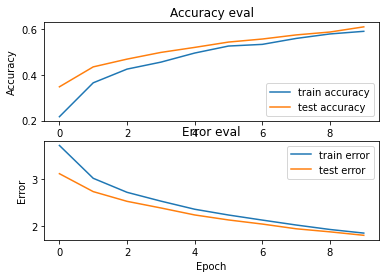

In [15]:
plot_history(history)

In [44]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

2497/1 - 1s - loss: 1.0061 - accuracy: 0.7169

Test accuracy: 0.71686023


In [23]:
model.save(os.path.join('..','front','my_model'))


INFO:tensorflow:Assets written to: ..\front\my_model\assets


In [28]:
from tensorflow.keras.models import load_model

In [29]:
new_model = load_model(os.path.join('..','front','my_model'))


In [45]:
# Get accuracy for each music genre
from sklearn.metrics import confusion_matrix

# prediction
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred,1)

In [46]:
# accuracy
matrix = confusion_matrix(y_test, y_pred)
accuracy = list(matrix.diagonal()/matrix.sum(axis=1))

#print beautifully
music_folder = os.path.join('..','data')
genres = [f for f in os.listdir(music_folder)]
print('Here is a list with the Accuracy of each music genre')
print(' ')
print(f"Total model: {test_acc}")
print(' ')
for a,b in zip(genres, accuracy):
    print(f"{a}: {round(b,2)}")

Here is a list with the Accuracy of each music genre
 
Total model: 0.7168602347373962
 
blues: 0.62
classical: 0.95
country: 0.71
disco: 0.74
hiphop: 0.7
jazz: 0.79
metal: 0.88
pop: 0.77
reggae: 0.55
rock: 0.43
